In [1]:
from utility.utility_general import *
from utility.util_tf import *
from utility import util_tf
import utility.util_plot as Plots
import image_generator, imp, ml_tools, plots_tools
imp.reload(image_generator)
imp.reload(ml_tools)
imp.reload(plots_tools)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, \
    roc_curve, auc
import seaborn as sns

## Initializing variables

In [2]:
notebook_filename = 'train_cnn_d9_encoder_1_r3.ipynb'
gpu_n = 0
data_set_num = 9
mlp_nodes_p_layer = 13
epochs = 20
over_sample = True

design_num = {13: 1, 7:2}
design_num = design_num[mlp_nodes_p_layer]
data_set_path = data_path + f'/data_sets/data_set_{data_set_num}/'
result_dir = f'results/train_cnn_3/design_{design_num}/' \
             f'data_set_{data_set_num:02}/cnn-3-{mlp_nodes_p_layer}-{data_set_num}' \
             + notebook_filename.split('.ipynb')[0]

random_seed = 0

tot_time_1 = datetime.now()
gpu_device = f'/device:GPU:{gpu_n}'
print(f'{"Executable": <15}: ', sys.executable)
print(f'{"Results": <15}: ', result_dir)

Executable     :  /home/adavar2/anaconda3/envs/tfgpu2/bin/python
Results        :  results/train_cnn_3/design_1/data_set_09/cnn-3-13-9train_cnn_d9_encoder_1_r3


## Configure GPU
* [Disable first GPU](https://www.tensorflow.org/api_docs/python/tf/config/set_visible_devices)
* [Restrict to first GPU](https://www.tensorflow.org/guide/gpu)

In [3]:
util_tf.tf_select_gpu(gpu_n)
makedirs(result_dir, exist_ok=True)

Total Num. GPUs Available:  6
6 Physical GPUs, 1 Logical GPU

Selected resources:
/physical_device:CPU:0
/physical_device:GPU:0


## Preparing data set
### Loading files into generators

In [4]:
print('Data set: ', data_set_path)
train_generator = image_generator.ImageGeneratorDataFrame(data_set_path + 'train.csv', over_sample=over_sample)
test_generator = image_generator.ImageGeneratorDataFrame(data_set_path + 'test.csv')
dev_generator = image_generator.ImageGeneratorDataFrame(data_set_path + 'dev.csv')

print(f'{"Train stats": <15}: ', end='')
train_generator.stats()
print(f'{"Dev stats": <15}: ', end='')
dev_generator.stats()
print(f'{"Test stats": <15}: ', end='')
test_generator.stats()

Data set:  /home/adavar2/Data/syn/data_sets/data_set_9/
Before oversampling: Tot. samples= 1,764  [Pos.= 1,464 - Neg.=   300(17.0%)]
After oversampling: Tot. samples= 2,928  [Pos.= 1,464 - Neg.= 1,464(50.0%)]
Train stats    : Tot. samples= 2,928  [Pos.= 1,464 - Neg.= 1,464(50.0%)]
Dev stats      : Tot. samples=   756  [Pos.=   640 - Neg.=   116(15.3%)]
Test stats     : Tot. samples= 1,080  [Pos.=   896 - Neg.=   184(17.0%)]


## Creating the model

In [5]:
from keras.models import Sequential
from keras.layers import Input, Conv3D, Flatten, Dense, MaxPooling3D, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence
import keras.backend as K
import models
from keras import layers

input_shape = (128, 128, 128, 3)
auto_encoder = models.CAE(input_shape=input_shape, pool_size=[4, 4, 4], optimizer='adam', 
                                     metrics=['accuracy'], channels=[32, 32, 32])
auto_encoder = auto_encoder.generate()
cae_1 = auto_encoder
for i in range(len(cae_1.layers)):
    if ('encode' in cae_1.layers[-1].name) or ('pooling' in cae_1.layers[-1].name):
        break
    cae_1.pop()
cae_1.add(layers.Flatten())
cae_1.add(layers.Dense(mlp_nodes_p_layer))
cae_1.add(layers.Dense(mlp_nodes_p_layer))
cae_1.add(layers.Dense(mlp_nodes_p_layer))
cae_1.add(layers.Dense(1, activation='sigmoid'))
cnn = cae_1
cnn.summary()
model = cnn


MODEL 5 adjustable params:
input_shape: (128, 128, 128, 3)
channels: [32, 32, 32]
kernel_size: (3, 3, 3)
activation: ['relu', 'sigmoid']
pool_size: [(4, 4, 4), (4, 4, 4), (4, 4, 4)]
loss: binary_crossentropy
optimizer: adam
metrics: ['accuracy']
verbose: True
dropout_rate: None
kernel_regularizer: None

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 128, 128, 128, 32) 2624      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 128, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 32, 32, 32, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 32, 32, 32, 32)    27680     
_________________________________________________________________
activation_1 (

## Preparing Loggers

In [6]:
from keras.callbacks import CSVLogger

model_checkpoint = ModelCheckpoint(
    result_dir + '/weights{epoch:04d}.h5',
    monitor='val_acc',
    verbose=1,
    #                                    save_best_only=True,
    #                                    mode='max',
    save_weights_only=True,
    save_freq='epoch')
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=15,
                          verbose=1,
                          mode='auto')
csv_logger = CSVLogger(result_dir + '/training.log',
                       separator=',',
                       append=True)
# tb_callback = tf.keras.callbacks.TensorBoard(log_dir= result_dir + "/tensor_board_logs",
#                                              histogram_freq=1,
#                                              write_graph=False,
#                                              write_images=True,
#                                              update_freq=1000,
#                                              profile_batch=2,
#                                              embeddings_freq=0,
#                                             )


callbacks = [earlystop, model_checkpoint, csv_logger]

## Training

In [7]:
time_1 = datetime.now()
util_tf.random_seed(random_seed)

with tf.device(gpu_device):
    history = model.fit(
        train_generator, 
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=dev_generator,
        validation_steps=len(dev_generator),
        callbacks=callbacks,
        verbose=1,
#         use_multiprocessing=True,
#         workers=32,
#         max_queue_size=20,
                                 )
    
time_2 = datetime.now()
print('End of the training. Run time:', str(time_2-time_1)[:-7])

Epoch 1/20
2928/2928 [==============================] - 178s 58ms/step - loss: 0.4058 - accuracy: 0.8011 - val_loss: 0.3394 - val_accuracy: 0.9034

Epoch 00001: saving model to results/train_cnn_3/design_1/data_set_09/cnn-3-13-9train_cnn_d9_encoder_1_r3/weights0001.h5
Epoch 2/20
2928/2928 [==============================] - 172s 59ms/step - loss: 0.1492 - accuracy: 0.9402 - val_loss: 0.3123 - val_accuracy: 0.9233

Epoch 00002: saving model to results/train_cnn_3/design_1/data_set_09/cnn-3-13-9train_cnn_d9_encoder_1_r3/weights0002.h5
Epoch 3/20
2928/2928 [==============================] - 169s 58ms/step - loss: 0.1146 - accuracy: 0.9640 - val_loss: 0.0985 - val_accuracy: 0.9537

Epoch 00003: saving model to results/train_cnn_3/design_1/data_set_09/cnn-3-13-9train_cnn_d9_encoder_1_r3/weights0003.h5
Epoch 4/20
2928/2928 [==============================] - 167s 57ms/step - loss: 0.0804 - accuracy: 0.9719 - val_loss: 0.1210 - val_accuracy: 0.9458

Epoch 00004: saving model to results/train_cn

In [8]:
model.save(result_dir + '/model.h5')
pd.DataFrame(model.history.history).to_csv(result_dir + '/history.csv', index=False)

### History Plots (Loss & Accuracy)

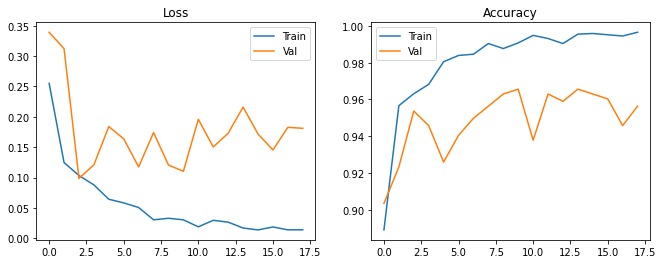

In [9]:
# Plot training curves
hist = history.history

plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend(["Train", "Val"])
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.legend(["Train", "Val"])
plt.title("Accuracy")
plt.show()

In [10]:
from keras.models import load_model
loaded_model = load_model(result_dir + '/model.h5')

In [11]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))
!cp $notebook_filename $result_dir/
!jupyter nbconvert $notebook_filename --to html --output-dir $result_dir

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook train_cnn_d9_encoder_1_r3.ipynb to html
[NbConvertApp] Writing 666441 bytes to results/train_cnn_3/design_1/data_set_09/cnn-3-13-9train_cnn_d9_encoder_1_r3/train_cnn_d9_encoder_1_r3.html


### Evaluating the test set

In [12]:
# Loading the trained model

from keras.models import load_model

trained_model = load_model(result_dir + '/model.h5')
trained_model.load_weights(result_dir + '/weights0006.h5')

In [13]:
# Evaluating the test data

with tf.device(gpu_device):
    yp = trained_model.predict(
        test_generator, 
        steps=len(test_generator),
        verbose=1,
#         use_multiprocessing=True,
#         workers=32,
        max_queue_size=10,
                                 )
    
yp_test = pd.DataFrame({
    'y': test_generator.get_labels(),
    'yp': yp.flatten(), #* 2 - 1
    'ypl': np.sign(np.sign(yp.flatten() - 0.5) + .5),
})
yp_test.to_csv(result_dir + '/yp_test.csv', index=False)

1080/1080 [==============================] - 54s 50ms/step


### ROC curve

Test accuracy (samples=1,080) = 93.70%


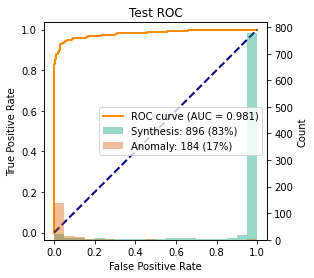

In [14]:
# Metrics on test data
yp_test = pd.read_csv(result_dir + '/yp_test.csv')

print('Test accuracy (samples={:,}) = {:.2f}%'.
      format(len(yp_test), 100 * accuracy_score(yp_test['y'], yp_test['ypl'])))
ml_tools.plot_roc_curve(y=yp_test['y'], yp=yp_test['yp'])
plt.title('Test ROC')
pass

## Testing different data sets

In [15]:
df_cs = pd.read_csv(data_path + '/data_sets/electrode_thermoelectric_materials.csv')
cs_generator = image_generator.ImageGeneratorDataFrame(df_cs)

util_tf.random_seed(random_seed)
with tf.device(gpu_device):
    yp = trained_model.predict(
        cs_generator, 
        steps=len(cs_generator),
        verbose=1,
        max_queue_size=10,
    )

2569/2569 [==============================] - 121s 47ms/step


In [16]:
yp_cs = pd.DataFrame({
    'type': df_cs['type'],
    'db': df_cs['db'],
    'y': cs_generator.get_labels(),
    'yp': yp.flatten(), #* 2 - 1
    'ypl': np.sign(np.sign(yp.flatten() - 0.5) + .5),
    'file': df_cs['file'],
})
yp_cs.to_csv(result_dir + '/yp_cs.csv', index=False)

### Electrode - COD materials

Data set cod size = 264
Data set mp size = 1,824


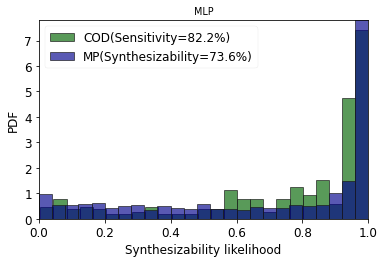

In [17]:
yp_cs = pd.read_csv(result_dir + '/yp_cs.csv')
df = yp_cs[yp_cs['type']=='electrode']
plots_tools.plot_electrode_thermoelectric_distribution(df)

### Thermoelectric - COD materials

Data set cod size = 56
Data set mp size = 66


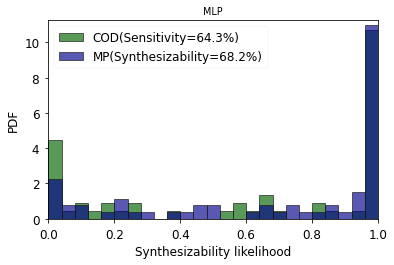

In [18]:
df = yp_cs[yp_cs['type']=='thermoelectric']
plots_tools.plot_electrode_thermoelectric_distribution(df)

## Saving the notebook and release GPU

In [ ]:
util_tf.tf_reset_gpu() # Releasing allocated GPUs
tot_time_2 = datetime.now()
print('End of the training. Run time:', str(tot_time_2-tot_time_1)[:-7])

In [ ]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();')) # Saving the notebook
!cp $notebook_filename $result_dir/
!jupyter nbconvert $notebook_filename --to html --output-dir $result_dir

# Saving other python files into a tarfile
import tarfile
with tarfile.open(f'{result_dir}/codes.tar', "w") as tar:
    py_files = list_all_files('./', pattern='*.py', recursive=False)
    py_files += list_all_files('./utility/', pattern='*.py', recursive=False)
    for f in py_files:
        tar.add(f, arcname=os.path.basename(f))
display(Javascript('IPython.notebook.save_checkpoint();')) # Saving the notebook